# Persistence Barcodes from cleaned spike data

Uses code from torus grid cell paper

Input: cleaned spike data in a pickle file organized by (datas, recordings)
Output: persistence barcode for H0-H2

Author: @emilyekstum & that other paper
<br> 11/17/25

paper: Gardner, R.J., Hermansen, E., Pachitariu, M. et al. Toroidal topology of population activity in grid cells. Nature 602, 123–128 (2022). https://doi.org/10.1038/s41586-021-04268-7

"fuzzy UMAP" details
1. build a fuzzy knn graph w greedy fps on weights
    - pick most connected points and down-weight points that are close to picked point
    - next point chosen is in less-covered parts of the data space
2. build distances and knn graph
3. UMAP-ish scale estimation (what they used from OG UMAP algorithm)
    - finds a sigma (scaling factor for dist between points) and rho (dist to nearest neighbor) for each point so that soft membership >= log2(k)
        - describes how fast to decay memberships to neighbors
4. knn -> fuzzy graph
    - sparse adj matrix = fuzzy simplicial set -> di fuzzy graph
5. identify most connected points and use greedy sampling w decay
    - fuzzy UMAP similarity used instead of geometric dist (link to topology)
6. pairwise fuzzy similarities matrix input to ripser

In [1]:
import cebra
import itertools
import os
import torch
import matplotlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# CODE FROM PAPER - and sparsely documented

from datetime import datetime 
import functools
import glob
from gudhi.clustering.tomato import Tomato
#import h5py
import matplotlib
from matplotlib import animation, cm, transforms, pyplot as plt, gridspec as grd
from matplotlib.collections import PathCollection
import numba
import numpy as np
from ripser import Rips, ripser
from scipy import stats, signal, optimize
from scipy.optimize import minimize
import scipy.io as sio
from scipy.ndimage import gaussian_filter,  gaussian_filter1d, rotate, binary_dilation, binary_closing
from scipy.stats import binned_statistic_2d, pearsonr, multivariate_normal
from scipy.special import factorial
from scipy.spatial.distance import cdist, pdist, squareform
import scipy.stats
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score
import sys
import time
import os

_LOG_2PI = np.log(2 * np.pi)

## Note, the following funtion is imported from the UMAP library
@numba.njit(parallel=True, fastmath=True) 
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals

## Note, the following funtion is imported from the UMAP library
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance

#
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho

def smooth_image(img, sigma):
    filterSize = max(np.shape(img))
    grid = np.arange(-filterSize+1, filterSize, 1)
#    covariance = np.square([sigma, sigma])
    xx,yy = np.meshgrid(grid, grid)

    pos = np.dstack((xx, yy))

    var = multivariate_normal(mean=[0,0], cov=[[sigma**2,0],[0,sigma**2]])
    k = var.pdf(pos)
    k = k/np.sum(k)

    nans = np.isnan(img)
    imgA = img.copy()
    imgA[nans] = 0
    imgA = scipy.signal.convolve2d(imgA, k, mode='valid')
#    imgA = gaussian_filter(imgA, sigma = sigma, mode = mode)
    imgD = img.copy()
    imgD[nans] = 0    
    imgD[~nans] = 1
    radius = 1
    L = np.arange(-radius, radius + 1)
    X, Y = np.meshgrid(L, L)
    dk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    imgE = np.zeros((filterSize+2,filterSize+2))
    imgE[1:-1,1:-1] = imgD
    imgE= binary_closing(imgE,iterations =1, structure =dk)
    imgD = imgE[1:-1,1:-1]

    imgB = np.divide(scipy.signal.convolve2d(imgD, k, mode='valid'), scipy.signal.convolve2d(np.ones(np.shape(imgD)), k, mode='valid'))
    imgC = np.divide(imgA,imgB)
    imgC[imgD==0] = -np.inf
    return imgC

def smooth_tuning_map(mtot, numangsint, sig, bClose = True):
    numangsint_1 = numangsint-1
    mid = int((numangsint_1)/2)
    indstemp1 = np.zeros((numangsint_1,numangsint_1), dtype=int)
    indstemp1[indstemp1==0] = np.arange((numangsint_1)**2)
    indstemp1temp = indstemp1.copy()
    mid = int((numangsint_1)/2)
    mtemp1_3 = mtot.copy()
    for i in range(numangsint_1):
        mtemp1_3[i,:] = np.roll(mtemp1_3[i,:],int(i/2))
    mtot_out = np.zeros_like(mtot)
    mtemp1_4 = np.concatenate((mtemp1_3, mtemp1_3, mtemp1_3),1)
    mtemp1_5 = np.zeros_like(mtemp1_4)
    mtemp1_5[:, :mid] = mtemp1_4[:, (numangsint_1)*3-mid:]  
    mtemp1_5[:, mid:] = mtemp1_4[:,:(numangsint_1)*3-mid]      
    if bClose:
        mtemp1_6 = smooth_image(np.concatenate((mtemp1_5,mtemp1_4,mtemp1_5)) ,sigma = sig)
    else:
        mtemp1_6 = gaussian_filter(np.concatenate((mtemp1_5,mtemp1_4,mtemp1_5)) ,sigma = sig)
    for i in range(numangsint_1):
        mtot_out[i, :] = mtemp1_6[(numangsint_1)+i, 
                                          (numangsint_1) + (int(i/2) +1):(numangsint_1)*2 + (int(i/2) +1)] 
    return mtot_out

#
def sample_denoising(data,  k = 10, num_sample = 500, omega = 0.2, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)
    if metric in ("cosine", "correlation", "dice", "jaccard"):
        angular = True
    else:
        angular = False
    
    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = np.zeros(num_sample, dtype = int)
    inds[0] = i
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds[j] = i
    d = np.zeros((num_sample, num_sample))
    
    for j,i in enumerate(inds):
        d[j,:] = X[i, inds]
    return inds, d, Fs


def normscale(X):
    return (X- np.min(X))/(np.max(X)-np.min(X))



def normit(xxx):
    xx = xxx-np.min(xxx)
    xx = xx/np.max(xx)
    return(xx)
    
def unique(list1):
    return(list(set(list1)))

def get_isi_acorr(spk, maxt = 0.2, res = 1e-3, thresh = 0.02, bLog = False, bOne = False):
    if bLog:
        num_bins = 100
        bin_times = np.ones(num_bins+1)*10
        bin_times = np.power(bin_times, np.linspace(np.log10(0.005), log10(maxt), num_bins+1))
        bin_times = np.unique(np.concatenate((-bin_times, bin_times)))
        num_bins = len(bin_times)
    elif bOne:
        num_bins = int(maxt/res)+1
        bin_times = np.linspace(0,maxt, num_bins)
    else:
        num_bins = int(2*maxt/res)+1
        bin_times = np.linspace(-maxt,maxt, num_bins)
    num_neurons = len(spk)
    acorr = np.zeros((num_neurons, len(bin_times)-1), dtype = int)    
#    print(bin_times)
    
    maxt-=1e-5
    mint = -maxt
    if bOne:
        mint = -1e-5
    for i, n in enumerate(spk):
        spike_times = spk[n]
        for ss in spike_times:
            stemp = spike_times[(spike_times<ss+maxt) & (spike_times>ss+mint)]
            dd = stemp-ss
            
            acorr[i,:] += np.bincount(np.digitize(dd, bin_times)-1, minlength=num_bins)[:-1]
    return acorr

def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)
    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1
  
    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)
    f = lsmr(Aw, Bw)[0]%1
    return f, verts



#
def plot_barcode(persistence, file_name = '', name = ''):

    diagrams_roll = {}
    filenames=glob.glob('Results/Roll/' + file_name + '_H2_roll_*')
    for i, fname in enumerate(filenames): 
        f = np.load(fname, allow_pickle = True)
        diagrams_roll[i] = list(f['diagrams'])
        f.close() 

    cs = np.repeat([[0,0.55,0.2]],3).reshape(3,3).T
    alpha=1
    inf_delta=0.1
    legend=True
    colormap=cs
    maxdim = len(persistence) - 1
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)

    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0])
        for i in np.arange(1,num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        min_birth = min(min_birth, np.min(persistence_dim))
        max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure()
    gs = grd.GridSpec(len(dims),1)

    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$", "$H_3$"] #, "$H_2$"
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        #axes.axis('off')
        axes.set_ylabel(f"H{dim}", fontsize=8)
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        dinds = np.argsort(dlife)[-30:]
        dl1,dl2 = dlife[dinds[-2:]]
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [0, indsall], c = 'k', linestyle = '-', lw = 1)
        axes.plot([0,indsall],[0,0], c = 'k', linestyle = '-', lw = 1)
        axes.tick_params(labelsize=5)
        axes.set_yticks([])
        axes.set_xlim([0, infinity])


def get_corr_dist(masscenters_1,masscenters_2, mtot_1, mtot_2):
    sig = 2.75
    num_shuffle = 1000
    numangsint = 51
    num_neurons = len(masscenters_1[:,0])
    cells_all = np.arange(num_neurons)
    corr = np.zeros(num_neurons)
    corr1 = np.zeros(num_neurons)
    corr2 = np.zeros(num_neurons)

    for n in cells_all:
        m1 = mtot_1[n,:,:].copy()
        m1[np.isnan(m1)] = np.mean(m1[~np.isnan(m1)])
        m2 = mtot_2[n,:,:].copy()
        m2[np.isnan(m2)] = np.mean(m2[~np.isnan(m2)])
        m1 = smooth_tuning_map(np.rot90(m1), numangsint, sig, bClose = False)
        m2 = smooth_tuning_map(np.rot90(m2), numangsint, sig, bClose = False)
        corr[n] = pearsonr(m1.flatten(), m2.flatten())[0]
        mtot_1[n,:,:]= m1
        mtot_2[n,:,:]= m2


    dist =  np.sqrt(np.sum(np.square(np.arctan2(np.sin(masscenters_1 - masscenters_2),
                                  np.cos(masscenters_1 - masscenters_2))),1))
    dist_shuffle = np.zeros((num_shuffle, num_neurons))
    corr_shuffle = np.zeros((num_shuffle, num_neurons))
    np.random.seed(47)
    for i in range(num_shuffle):
        inds = np.arange(num_neurons)
        np.random.shuffle(inds)
        for n in cells_all:
            corr_shuffle[i,n] = pearsonr(mtot_1[n,:,:].flatten(), mtot_2[inds[n],:,:].flatten())[0]
        dist_shuffle[i,:] =  np.sqrt(np.sum(np.square(np.arctan2(np.sin(masscenters_1 - masscenters_2[inds,:]),
                np.cos(masscenters_1 - masscenters_2[inds,:]))),1))

    return corr, dist, corr_shuffle, dist_shuffle


def random_combinations(matrix, size):
    seen = set()
    n = len(matrix)
    while True:
        new_sample = tuple(sorted(random.sample(range(n), size)))
        if new_sample not in seen:
            seen.add(new_sample)
            yield tuple(matrix[i] for i in new_sample)



In [ ]:
# load in data from pickle
with open(os.path.join("C:\\Users\\......\\data\\clean_spike_data", "LGN_color_exchange"), "rb") as f:  # path to cleaned spike data on your machine
    loaded = pkl.load(f)
    datas = loaded['datas']
    recordings = loaded['recordings']
    good_recordings = ['C161']

In [11]:
# downsample data - really a must if you want this to run within a reasonable time

downsample_factor = 250 # adjust as needed
downsampled_datas = [] 
for name, X in enumerate(datas):
    if isinstance(X, torch.Tensor):
        down = X[::downsample_factor, :]
    else:
        down = X[::downsample_factor].copy()
    downsampled_datas.append(down)
    print(f"Downsampled to {down.shape}")


Downsampled to (136, 44)
Downsampled to (136, 90)
Downsampled to (136, 90)
Downsampled to (136, 150)
Downsampled to (136, 15)
Downsampled to (136, 150)
Downsampled to (136, 55)
Downsampled to (136, 91)


PCA done for d4 (n_samples=136, n_components=32)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


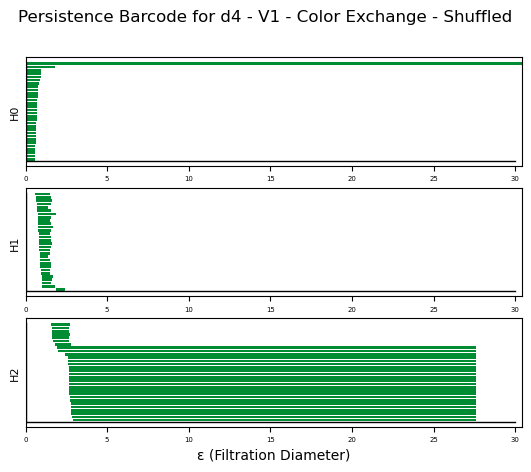

PCA done for d5 (n_samples=136, n_components=54)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


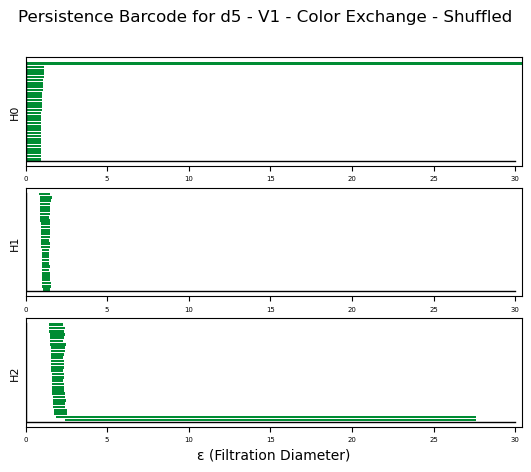

PCA done for d6 (n_samples=136, n_components=55)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


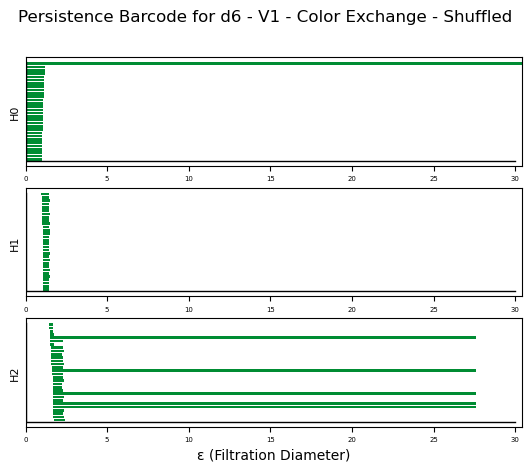

PCA done for C153 (n_samples=136, n_components=73)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


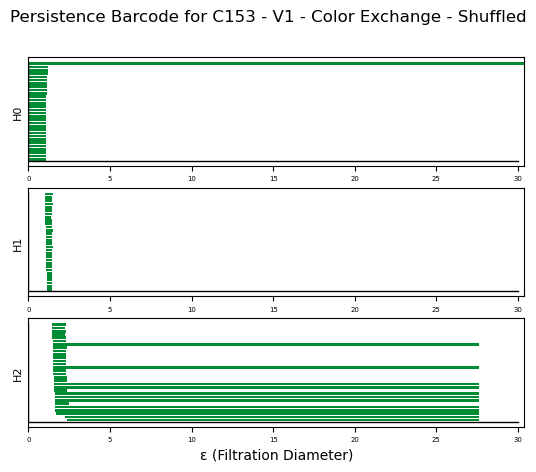

PCA done for C155 (n_samples=136, n_components=15)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


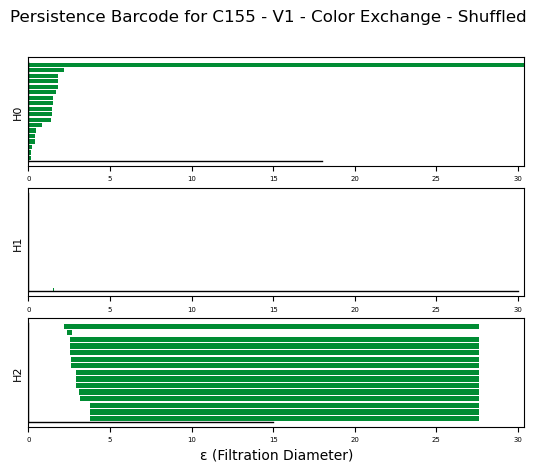

PCA done for C159 (n_samples=136, n_components=74)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


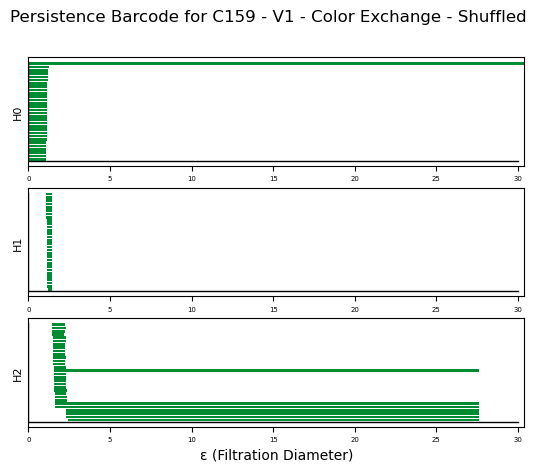

PCA done for C160 (n_samples=136, n_components=39)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


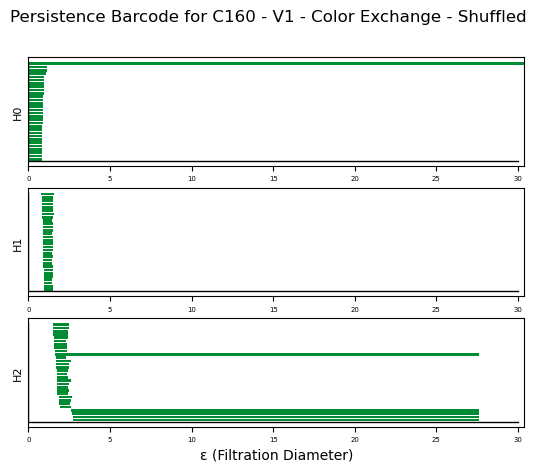

PCA done for C161 (n_samples=136, n_components=56)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


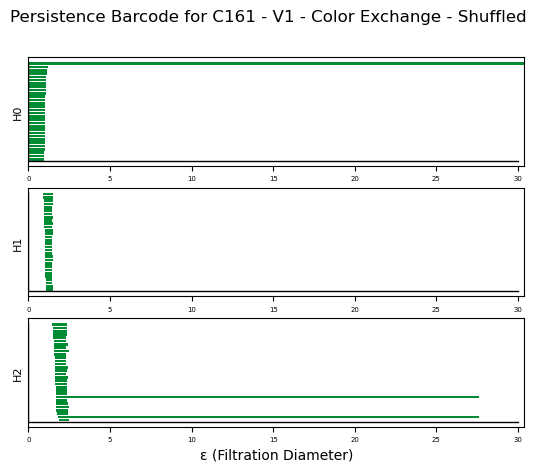

In [ ]:
# from toroidal paper - code for preprocessing and ripser
# commented out values are the params used in the paper- reduced for speed

#params
#dim = 6
ph_classes = [0,1,2]
metric = 'cosine'
maxdim = 2
coeff = 2 # 47 -> coefficient field, 2 = orientation doesn't matter
n_points = 136  # how many points to use in denoising - main downsampling parameter (set to same number as downsampled data for no downsampling)
nbs = n_points // 3  #number of neighbors for umap
sigma = 1500

for name, X in zip(recordings, downsampled_datas):
    X_scaled = StandardScaler().fit_transform(X)

    # optimize k for least dims that explain 90% variance but at least 32, and not more than min(n_samples, n_features)
    pca_full = PCA(svd_solver='auto', random_state=42).fit(X_scaled)
    sum_var = np.cumsum(pca_full.explained_variance_ratio_)
    k = max(32, np.searchsorted(sum_var, 0.9)+1)
    k = min(k, min(X_scaled.shape))  # Ensure k does not exceed min(n_samples, n_features)

    pca = PCA(n_components=k, svd_solver='auto', random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA done for {name} (n_samples={X.shape[0]}, n_components={k})")

    #dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
    indstemp,dd,fs  = sample_denoising(X_pca,  k,  
                                        n_points, 1, metric)
    dim_red_spikes_move_scaled = X_pca[indstemp,:]
    dist_mat = squareform(pdist(X_pca, metric))
    print("Denoising done")

    # Constructing the fuzzy simplicial set with KNN
    knn_indices = np.argsort(dist_mat)[:, :nbs]
    knn_dists = dist_mat[np.arange(dist_mat.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    print("KNN done")

    # Compute the membership strengths of KNN
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    print("Membership strengths done")
    result = coo_matrix((vals, (rows, cols)), shape=(dist_mat.shape[0], dist_mat.shape[0])) #change to csr for speed?
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()

    # negative log transform
    # clamp tiny/zero values to avoid -inf / numerical issues
    d = np.clip(d, 1e-12, None)
    d = -np.log(d)
    print("Negative log transform done")

    # distance matrix
    np.fill_diagonal(d,0)
    print("Distance matrix done")

    # TDA
    # makes a plot with each row of the graphs as a homology group
    persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)
    print("Ripser done")    
    plot_barcode(persistence['dgms'])    
    plt.xlabel('ε (Filtration Diameter)') # or is it radius?
    plt.suptitle(f'Persistence Barcode for {name} - V1 - Color Exchange - Shuffled')
    plt.show()
